In [1]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
import math

df= gpd.read_file("C:/Users/Melis/Desktop/data/yapi/yapi.shp")

# 1. Step: Calculate side lengths of polygons
df['edge_lengths'] = df['geometry'].apply(lambda geom: [LineString(list(geom.exterior.coords)).length])

D:\ANACONDO_3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.2-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
C:\Users\Melis\AppData\Local\Temp\ipykernel_6780\1290627913.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyG

In [2]:
# 2. Step: Identify polygons that share edges and which edges they share
shared_edges = []

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        intersection = df.iloc[i].geometry.intersection(df.iloc[j].geometry)
        if intersection.is_empty:
            continue
        elif intersection.geom_type == 'MultiLineString':
            for line in intersection.geoms:
                shared_edges.append((i, j, LineString(line.coords)))
        elif intersection.geom_type == 'LineString':
            shared_edges.append((i, j, LineString(intersection.coords)))

D:\ANACONDO_3\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [3]:
# 3. Step: Detect non-shared edges for each polygon
non_shared_edges_by_polygon = {}

for i in range(len(df)):
    non_shared_edges = []
    exterior_coords = list(df['geometry'].iloc[i].exterior.coords)
    for j in range(len(exterior_coords) - 1):
        edge_line = LineString([exterior_coords[j], exterior_coords[j+1]])
        is_shared = False
        for shared_edge in shared_edges:
            if i in (shared_edge[0], shared_edge[1]) and edge_line.equals(shared_edge[2]):
                is_shared = True
                break
        if not is_shared:
            non_shared_edges.append(edge_line)
    non_shared_edges_by_polygon[i] = non_shared_edges

In [4]:
# 4. Step: Detect the longest non-shared edges for each polygon
longest_non_shared_edges = {}

for i, non_shared_edges in non_shared_edges_by_polygon.items():
    longest_edge = max(non_shared_edges, key=lambda x: x.length)
    longest_non_shared_edges[i] = longest_edge

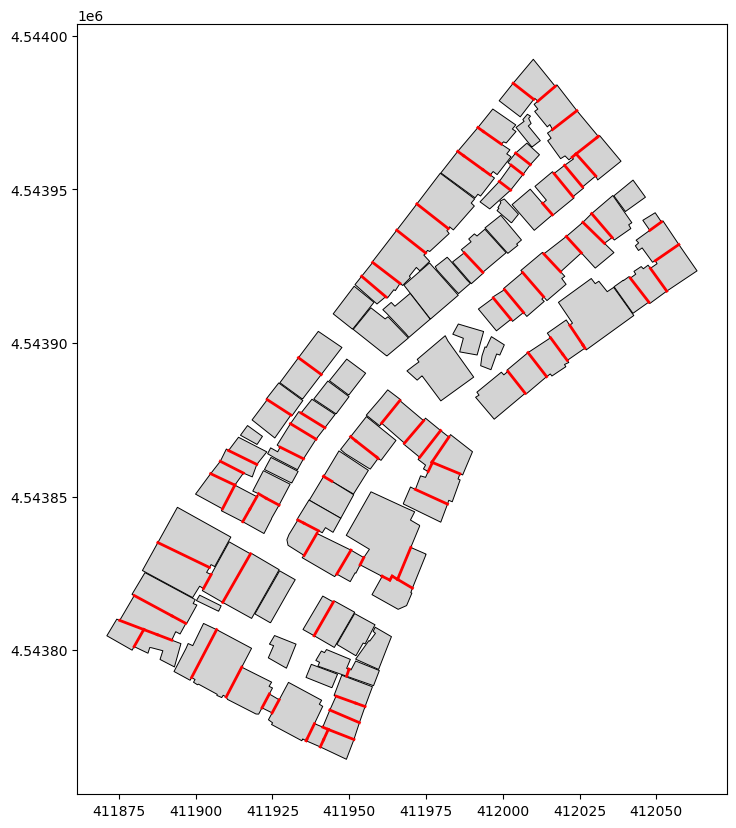

In [9]:
# 5. Step: visualization
from shapely.geometry import Polygon, MultiLineString

fig, ax = plt.subplots(figsize=(10, 10))

# Draw polygons
df.plot(ax=ax, facecolor='lightgray', edgecolor='black', linewidth=0.7)

# Draw shared edges
for edge in shared_edges:
    line = edge[2]
    if isinstance(line, MultiLineString):
        for subline in line.geoms:
            ax.plot(*subline.xy, color='red', linewidth=2)
    else:
        ax.plot(*line.xy, color='red', linewidth=2)

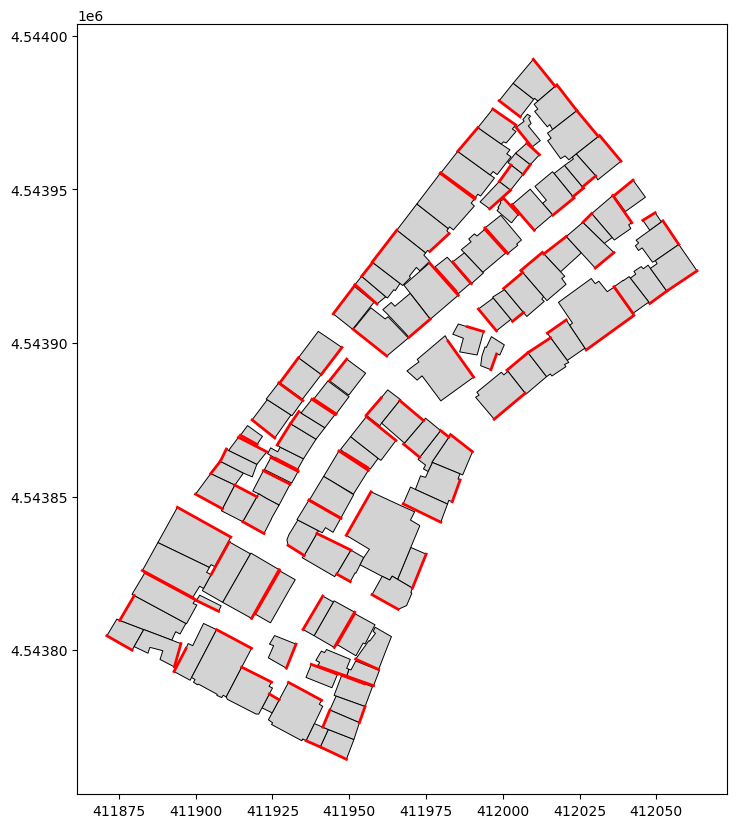

In [10]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Draw polygons
df.plot(ax=ax, facecolor='lightgray', edgecolor='black', linewidth=0.7)

# Draw the longest non-shared edge for each polygon
for i, longest_edge in longest_non_shared_edges.items():
    if isinstance(longest_edge, MultiLineString):
        for subline in longest_edge.geoms:
            ax.plot(*subline.xy, color='red', linewidth=2)
    else:
        ax.plot(*longest_edge.xy, color='red', linewidth=2)

plt.show()